<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Camera calibration</p>

In this part we will first work with the image sequence of the ``left`` directory that belong to the calibration of the left camera of an stereo camera. 


This sequence contains a series of images of the calibration template. For the calibration it should be taken into account that the size of each template slot is 30 mm in the $X$ and $Y$ axis.

In [117]:
import cv2
import glob
import copy
import math
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt

from pprint import pprint as pp

In [118]:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

In [119]:
!pip install imageio

You should consider upgrading via the 'C:\Users\pablo\Desktop\IMAT\Tercero\VisionOrdenador\Lab1\practica1 (1)\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [120]:
root = os.getcwd()
path = os.path.join(root, "left")
filenames = [i for i in glob.glob(path + '/*.jpg')]
imgs = load_images(filenames)

C:\Users\pablo\AppData\Local\Temp\ipykernel_11404\3789968186.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


The function ``cv2.findChessboardCorners`` of
OpenCV function finds the calibration template in an image and
returns a tuple of two elements. The first element
is 0 if it failed to successfully detect the template, and
is 1 otherwise. The second element contains the
coordinates of the corners of the calibration template,
which are only valid if the detection was successful, 
i.e. if the first element of the tuple is 1.

<hr>

**Use the function** ``cv2.findChessboardCorners``**, and optionally** ``cv2.cornerSubPix``**, to automatically detect the calibration pattern and its corners in all loaded images**. The size of the calibration stencil in the practice images is (8, 6), that is, 8 rows and 6 columns. It stores the results of the multiple calls in a list, so that the element $i$ in that list corresponds to the result of ``cv2.findChessboardCorners`` for the image $i$ loaded earlier.

In [121]:
#CALCULAR en la variable "corners" el valor de las posiciones de las esquinas de los patrones ilustrados en las imágenes 
#utilizando la función de openCV "findChessboardCorners". Ten en cuenta que esta función se deberá ejecutar por todas las 
#imágenes de tu set de calibración y que hay que tener en cuenta el tamaño del tablero que es (8,6)
corners = []
for img in imgs:
    ret, c = cv2.findChessboardCorners(img, (8,6),None)
    if ret:
        corners.append(c)
    else:
        corners.append(None)

In [122]:
# OPTIONAL => cornerSubPix is a destructive function. so we need to copy corners to avoid data loss
corners2 = copy.deepcopy(corners)

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

#utilizaremos la función de openCV "cornerSubPix" para refinar el valor de las esquinas calculadas. OJO que esta función necesita 
#que las imágenes del patrón de calibración estén en escala de grises primero
# PASA Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) for img in imgs]
# For each image and corners we are going to use cornerSubPix
#cornersRefined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_grey, corners2)]
cornersRefined = []
for i, cor in zip(imgs_grey, corners2):
    if cor is not None and cor.any():
        refined = cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria)
        cornersRefined.append(refined)
# pp(cornersRefined)

The next exercise consists of drawing on the images the points detected by ``cv.FindChessboardCorners``. For efficiency reasons, the function used to do this modifies directly the images passed by parameter instead of making a copy. To avoid losing the original images it is better to make a copy of them in advance. One way to do this is ``imgs2 = copy.deepcopy(imgs)``
where ``imgs`` is the list of loaded images. Use these copied images instead of the original ones in the
in the following exercise.

<hr>

**Use.**  ``cv2.drawChessboardCorners`` **to draw the corners detected in the previous exercise**. Apply it to all images that were correctly detected. Ignore the rest.

Display some results

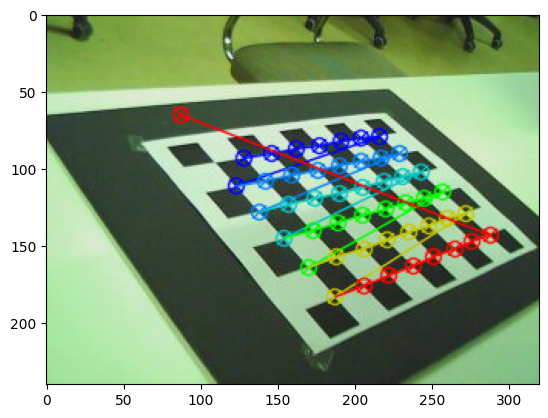

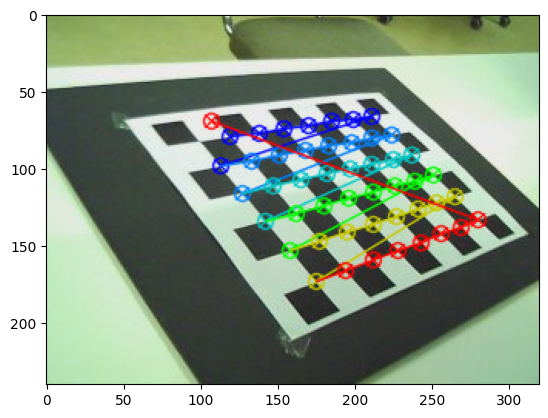

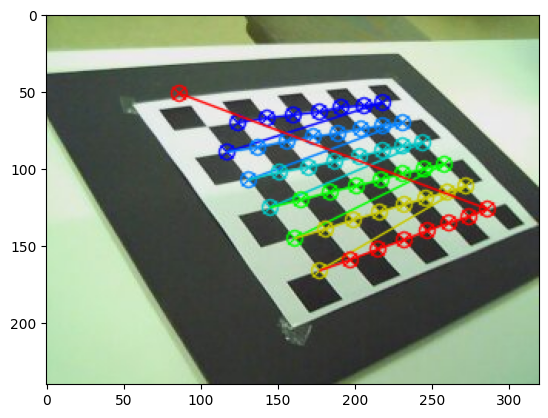

In [123]:
imgs2 = copy.deepcopy(imgs)
#IMPLEMENTAR la función "drawChessboardCorners" de openCV para visualizar las esquinas detectadas de los patrones de calibración
#Muestra al menos 3 imágenes originales y sus respectivas salidas de la función de openCV
imgs2.pop(0) #Quitamos la primera porque no la ha conseguido procesar
N_IMGS = 3images_w_corners = []
for i, cor in zip(imgs2, cornersRefined):
    images_w_corners.append(cv2.drawChessboardCorners(i,(8,6),cor,True))

for i in range(N_IMGS):
    plt.imshow(images_w_corners[i])
    plt.show()

To calibrate the camera, in addition to the coordinates of the corners in each of the images, the three-dimensional corner coordinates of the corners in the reference system of the scene.
 For this practice we will consider that the center of the reference system, i.e. the
point of coordinates $[0, 0, 0]^\top$, is the first corner of the calibration template detected in the scene's reference frame.
We will also consider that the X-axis corresponds to the short side of the calibration template, i.e., the coordinate point, and the Y-axis to the long side.
This arrangement implies that the Z-axis points in the upward normal direction of the calibration plane.


For the following exercise it is very important to take into account that the coordinates of the corners in the system of
scene reference should be given in the same order as
in which they were detected in each of the images.

<hr>

**Implement the function** ``get_chessboard_points (chessboard_shape, dx, dy)`` that will generate an array of `NumPy` (that is, an ndarray) of
size $ N × 3 $ with the coordinates $ (x, y, z) $ of the corners of
the calibration template in the reference system of the
scene. $ N $ is the number of corners in the template.

``chessboard_shape`` is the number of points per row
and by columns of the calibration template. Like
in Exercise 1, it should be (8, 6). `` dx`` (resp. `` dy``) is the width
(resp. high) of a square of the calibration template.
For the template used in this lab, both values
they are $30mm$.

In [124]:
def get_chessboard_points(chessboard_shape, dx, dy):
    #IMPLEMENT this function. It shall return a vector of 3 components where the third is zero.

    
#HINT: how to call the funtion:
cb_points = get_chessboard_points((8, 6), 30, 30)


IndentationError: expected an indented block (4234834564.py, line 6)

<hr>

**ASIGNMENT** Calibrate the left camera using the results list of `` cv2.findChessboardCorners``
and the set of model points given by `` get_chessboard_points``, from the previous exercise.

Save the result of the calibration, intrinsic matrix and extrinsic matrices, with the command
np.savez (‘calib_left’, intrinsic = intrinsic, extrinsic = extrinsic)

In [ ]:
# We are going to retrieve existing corners (cor[0] == True)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matrix with the coordinates of the corners
real_points = get_chessboard_points((8, 6), 30, 30)

# We are going to convert our coordinates list in the reference system to numpy array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convert the corners list to array
image_points = np.asarray(valid_corners, dtype=np.float32)

# ASIGNMENT: Calibrate the left camera
rms, intrinsics, dist_coeffs, rvecs, tvecs = #calibrate the camera (cv2.calibrateCamera)
# Calculate extrinsecs matrix using Rodigues on each rotation vector addid its translation vector
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
# Save the calibration file
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

# Lets print some outputs
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:\n", dist_coeffs)
print("root mean sqaure reprojection error:\n", rms)

<hr>

**ASIGNMENT** Repeat the procedure to calibrate the right camera too. In the end, print the calculated extrinsics and intrinsics parameters for both cameras.

Once finished, **please print the root mean square reprojection error and justify in the report its meaning.**

C:\Users\jglju\AppData\Local\Temp\ipykernel_7312\3789968186.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


Corners standard intrinsics:
 [[434.57693824   0.         144.28526493]
 [  0.         434.57693824 132.65635781]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs:
 [[-0.13453529 -0.09713635  0.00682929 -0.00876882  0.93177555]]
rms standard:
 0.20649698153368962


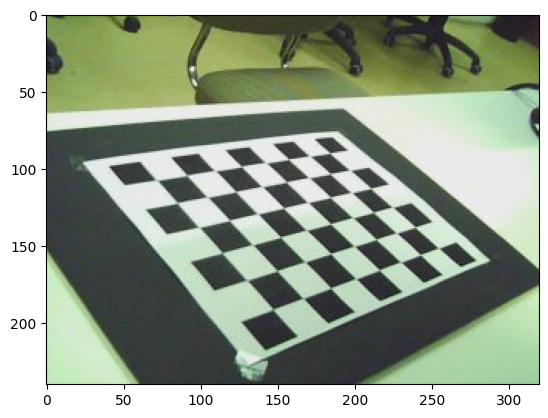

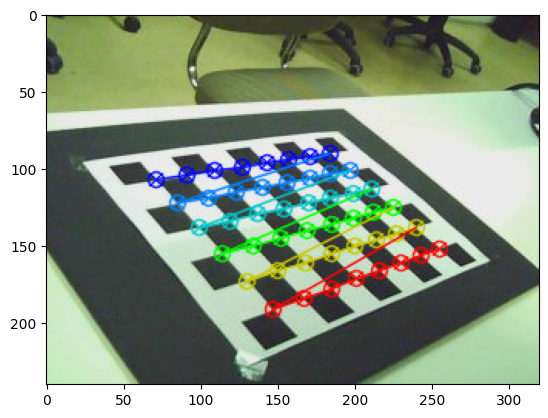

In [ ]:
#FILL THIS UP

# Calculate the extrinsecs with Rodrigues given the translation and rotation matrixes
extrinsics_r = list(map(lambda rvec_r, tvec_r: np.hstack((cv2.Rodrigues(rvec_r)[0], tvec_r)), rvecs_r, tvecs_r))
print("Extrinsc:\n",extrinsics_r)


<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Distortion correction</p>

In this part we will work on undistorting an image taken with a fisheye lens. First we will calibrate a fisheye camera and then we will use this calibration parameters to undistort one of the calibration images.

For this exercies, the calibration images are under "fisheye pattern" folder

In [ ]:
import cv2
import matplotlib.pyplot as plt
#print(cv2.__version__[0])
#assert cv2.__version__[0] == '3'    
#'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
CHECKERBOARD = (6,7)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('PATH TO FOLDER/*.jpg')
for fname in images:
    #IMPLEMENT AGAIN THE SAME CALIBRATION ALGORITHM AS BEFORE USING NOW THE DISTORTED CALIBRATION IMAGES
    #Use the "findChessboardCorners" function with the following configuration in its third parameter: cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK +cv2.CALIB_CB_NORMALIZE_IMAGE
    objpoints.append(objp)
    cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
    imgpoints.append(corners)
            
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
print(objpoints)
rms, _, _, _, _ = \
cv2.fisheye.calibrate(objpoints,imgpoints, gray.shape[::-1], K, D, rvecs, tvecs, calibration_flags, (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

[array([[[0., 0., 0.],
        [1., 0., 0.],
        [2., 0., 0.],
        [3., 0., 0.],
        [4., 0., 0.],
        [5., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [2., 1., 0.],
        [3., 1., 0.],
        [4., 1., 0.],
        [5., 1., 0.],
        [0., 2., 0.],
        [1., 2., 0.],
        [2., 2., 0.],
        [3., 2., 0.],
        [4., 2., 0.],
        [5., 2., 0.],
        [0., 3., 0.],
        [1., 3., 0.],
        [2., 3., 0.],
        [3., 3., 0.],
        [4., 3., 0.],
        [5., 3., 0.],
        [0., 4., 0.],
        [1., 4., 0.],
        [2., 4., 0.],
        [3., 4., 0.],
        [4., 4., 0.],
        [5., 4., 0.],
        [0., 5., 0.],
        [1., 5., 0.],
        [2., 5., 0.],
        [3., 5., 0.],
        [4., 5., 0.],
        [5., 5., 0.],
        [0., 6., 0.],
        [1., 6., 0.],
        [2., 6., 0.],
        [3., 6., 0.],
        [4., 6., 0.],
        [5., 6., 0.]]], dtype=float32), array([[[0., 0., 0.],
        [1., 0., 0.],
        [2., 

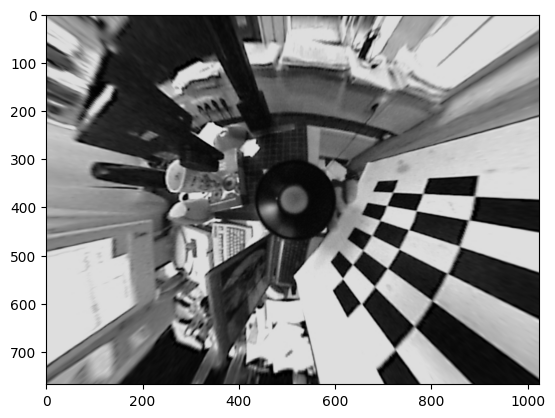

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
DIM=#USE THE VALUES FROM PREVIOUS EXERCISE
K=#USE THE VALUES FROM PREVIOUS EXERCISE
D=#USE THE VALUES FROM PREVIOUS EXERCISE
img = #load one of the calibration images taken with the fisheye camera
h,w = img.shape[:2]    
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
#incluye en el informe qué hay guardado en "map1" y "map2"
#USE THE cv2.remap function with linear interpolation to calculate the undistorted image. Show it finally and paste it in the report

